In [84]:
# 기본 데이터 처리 및 수치 계산 라이브러리
import numpy as np
import pandas as pd

# 시각화 라이브러리
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 파일과 이미지 처리 라이브러리
from PIL import Image

# 텍스트 처리 및 자연어 처리(NLP) 라이브러리
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup           
import contractions                    
from sklearn.feature_extraction.text import TfidfVectorizer

# 토픽 모델링 및 텍스트 마이닝 라이브러리
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models

# 데이터 구조 및 알고리즘 유틸리티
import itertools
from collections import Counter, defaultdict
from itertools import combinations

# 네트워크 분석 라이브러리
import networkx as nx

# 진행 상태 표시 및 반복 작업 진행 표시 라이브러리
from tqdm import tqdm
tqdm.pandas()

In [113]:
hanto=pd.read_csv('./한국투자증권 전처리.csv', encoding='utf-8-sig')

hanto

,score,리뷰내용,작성시간,사용자ID,리뷰추천수,전처리한 리뷰
0,5,이제 시작해봅니다....,2024.2.7 11:27,이인정,0,['시작']
1,5,편리해요,2024.3.19 13:33,A7,0,['편리']
2,5,계좌개설하고 주식선물도 받고 좋아요,2024.2.8 4:28,이봄,0,"['계좌', '개설', '주식', '받다', '좋다']"
3,5,감사합니다,2024.2.8 9:53,김상무,0,['감사']
4,5,굿입니다,2024.3.19 1:13,정태성,0,['좋다']
...,...,...,...,...,...,...
360,1,왜 어플 또 먹통이죠? 왜???,2024.3.11 3:09,백승태,0,"['앱', '먹통']"
361,1,앱 접속이 안됩니다. 앱 삭제 후 새로 설치까지 해보았는데 계속 안되네요.,2024.3.27 8:30,ᄋᄋᄋ,0,"['앱', '접속', '안', '앱', '삭제', '설치', '안']"
362,1,와이파이에서는 접속이 되는데 왜 모바일데이터로 설정하면 접속이 안되죠? 이증상이 수...,2024.2.27 13:45,조성현,0,"['접속', '되다', '모바일', '데이터', '설정', '접속', '안', '있..."
363,1,접속이 안됩니다 어떻게 된거죠,2024.2.28 5:54,김봉섭,0,"['접속', '안', '되다']"


# 한국투자

In [7]:
# 긍정적 리뷰(평점 5점 만점 기준 4, 5점)
hanto_pos = hanto[(4 == hanto['score']) | (hanto['score'] == 5)]
# 부정적 리뷰(평점 5점 만점 기준 1, 2점)
hanto_neg = hanto[(1 == hanto['score']) | (hanto['score'] == 2)]

In [13]:
review_num_neg = len(hanto_neg)
review_num_pos = len(hanto_pos)
review_num_tot = review_num_pos + review_num_neg

print(f"한국투자 리뷰 총 개수: {review_num_tot}")
print(f"한국투자 긍정적 리뷰: {review_num_pos}개({(review_num_pos/review_num_tot)*100:.2f}%)")
print(f"한국투자 부정적 리뷰: {review_num_neg}개({(review_num_neg/review_num_tot)*100:.2f}%)")

한국투자 리뷰 총 개수: 328
한국투자 긍정적 리뷰: 171개(52.13%)
한국투자 부정적 리뷰: 157개(47.87%)


## LDA

In [79]:
# '전처리한 리뷰' 열의 값들을 하나의 리스트로 모음
hanto_tokens = []
for review_list in hanto['전처리한 리뷰']:
    # eval 함수를 사용하여 문자열 형태의 리스트를 실제 리스트로 변환하여 추가
    hanto_tokens.extend(eval(review_list))

# 결과 확인
print(hanto_tokens)


['시작', '편리', '계좌', '개설', '주식', '받다', '좋다', '감사', '좋다', '사용', '편하다', '사용', '편하다', '빠르다', '좋다', '혜택', '좋다', '좋다', '처음', '빠르다', '사용', '주', '주식', '시작', '내용', '사용', '편하다', '편리', '좋다', '감사', '되다', '되다', '사용', '있다', '한국투자증권', '증권', '한국투자증권', '증권', '처음', '개설', '빠르다', '가다', '처음', '보다', '편하다', '쉽다', '되다', '주식', '좋다', '좋다', '모바일', '차트', '설정', '지표', '이상', '설정', '있다', '이상', '보다', '편하다', '한국투자증권', '증권', '보기', '좋다', '좋다', '좋다', '편리', '서비스', '추천', '편리', '혜택', '많다', '좋다', '이용', '사용', '편리', '좋다', '주식', '주', '처음', '좋다', '좋다', '편리', '갤럭시', '문제', '주식', '기능', '추가', '업데이트', '없다', '계좌', '개설', '좋다', '좋다', '사용', '편하다', '재접속', '메시지', '반복', '접속', '설치', '안', '문제', '확인', '부탁', '편하다', '앱', '빠르다', '좋다', '최고', '증권사', '한국투자증권', '좋다', '좋다', '좋다', '좋다', '한국투자증권', '증권', '앱', '좋다', '좋다', '추천', '가다', '최고', '사용', '편하다', '좋다', '쓰다', '있다', '앱', '쉽다', '좋다', '가다', '빠르다', '계좌', '개설', '사용', '처음', '좋다', '이벤트', '감사', '좋다', '추천', '처음', '한국투자증권', '증권', '주식', '좋다', '좋다', '쉽다', '편하다', '좋다', '시작', '좋다', '개설', '이용', '편리', '사용', '편리', '처음'

In [80]:
# 단어 빈도 계산
word_counts = Counter(hanto_tokens)

# 데이터 프레임 생성
df_freq = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])

# 빈도에 따라 데이터 프레임 내림차순 정렬
df_sorted = df_freq.sort_values(by='Frequency', ascending=False)

# 정렬된 데이터 프레임 출력
df_sorted.head(20)

,Word,Frequency
46,앱,120
6,좋다,97
43,안,75
16,있다,67
4,주식,53
15,되다,51
93,종목,42
20,보다,37
37,없다,37
2,계좌,36


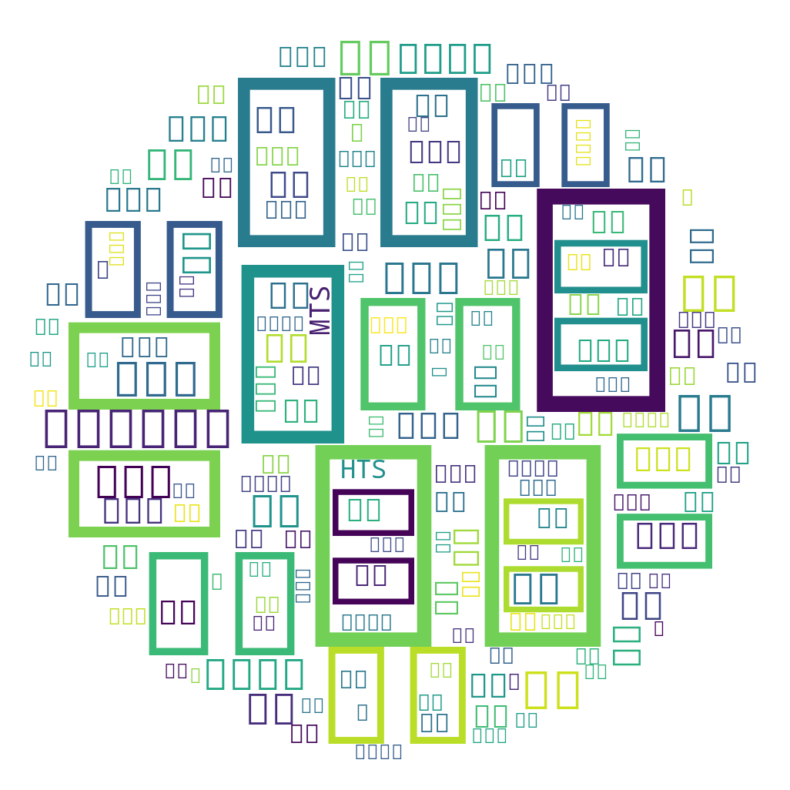

In [99]:
# 원형 마스크 생성
x, y = np.ogrid[:1000, :1000]  # 1000x1000 이미지

mask = (x - 500) ** 2 + (y - 500) ** 2 > 480 ** 2  # 원의 중심을 (500, 500)으로 하고 반지름은 480
mask = 255 * mask.astype(int)

# 워드 클라우드 생성
wordcloud = WordCloud(width=1000, 
                      height=1000, 
                      max_words= 500,
                      mask=mask,
                      background_color ='white').generate_from_frequencies(word_counts)

# 워드 클라우드 시각화sett
# 그래프 출력을 위한 설정
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams["font.size"] = 8
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False  # 한글 폰트 사용 시 마이너스 기호가 깨지는 문제 해결

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') # 축 표시 제거
plt.show()

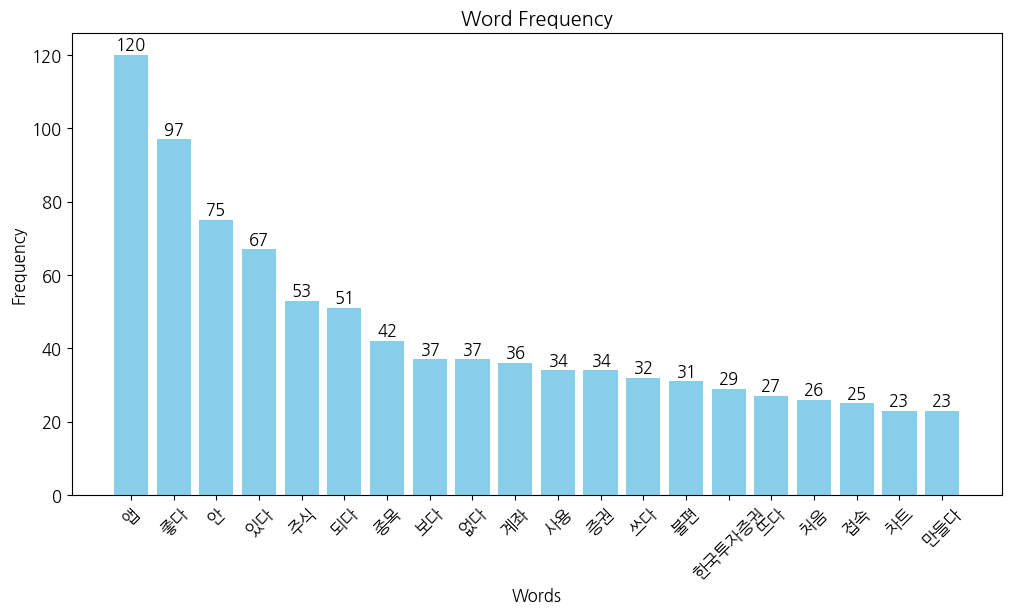

In [97]:
# 빈도수 추출
most_common_words = word_counts.most_common(20)
words, frequencies = zip(*most_common_words)  # 단어와 빈도수를 분리하여 리스트로 저장

# 막대그래프 생성
plt.figure(figsize=(12, 6))  # 그래프 크기 지정
bars = plt.bar(words, frequencies, color='skyblue')  # 막대그래프 설정

# 각 막대에 빈도 값 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom')

plt.xlabel('Words')  # x축 제목
plt.ylabel('Frequency')  # y축 제목
plt.title('Word Frequency')  # 그래프 제목
plt.xticks(rotation=45)  # x축 레이블 회전
plt.show() 

In [118]:
evaluated_reviews = [eval(review) for review in hanto['전처리한 리뷰']]
evaluated_reviews

[['시작'],
 ['편리'],
 ['계좌', '개설', '주식', '받다', '좋다'],
 ['감사'],
 ['좋다'],
 ['사용', '편하다'],
 ['사용', '편하다'],
 ['빠르다', '좋다'],
 ['혜택', '좋다'],
 ['좋다'],
 ['처음', '빠르다', '사용'],
 ['주', '주식', '시작'],
 ['내용'],
 ['사용', '편하다'],
 ['편리', '좋다'],
 ['감사'],
 ['되다', '되다', '사용', '있다'],
 ['한국투자증권', '증권'],
 ['한국투자증권', '증권', '처음', '개설', '빠르다', '가다'],
 ['처음', '보다', '편하다', '쉽다', '되다'],
 ['주식', '좋다'],
 ['좋다'],
 ['모바일', '차트', '설정', '지표', '이상', '설정', '있다', '이상'],
 ['보다', '편하다'],
 ['한국투자증권', '증권', '보기'],
 ['좋다'],
 ['좋다'],
 ['좋다'],
 ['편리', '서비스', '추천'],
 ['편리', '혜택', '많다', '좋다'],
 ['이용'],
 ['사용', '편리'],
 ['좋다'],
 ['주식', '주'],
 ['처음'],
 ['좋다', '좋다'],
 ['편리'],
 ['갤럭시', '문제', '주식', '기능', '추가', '업데이트', '없다'],
 ['계좌', '개설', '좋다'],
 ['좋다'],
 ['사용', '편하다'],
 ['재접속', '메시지', '반복', '접속', '설치', '안', '문제', '확인', '부탁'],
 ['편하다'],
 ['앱', '빠르다'],
 ['좋다'],
 ['최고', '증권사', '한국투자증권'],
 ['좋다', '좋다', '좋다'],
 ['좋다', '한국투자증권', '증권', '앱', '좋다'],
 ['좋다'],
 ['추천', '가다'],
 ['최고'],
 ['사용', '편하다'],
 ['좋다', '쓰다', '있다'],
 ['앱', '쉽다'],
 ['좋다'],
 ['가다'],


In [119]:
# 각 리뷰를 단어의 리스트로 변환
tokenized_doc = evaluated_reviews
# 동시 출현 빈도를 계산할 딕셔너리
co_occurrence = defaultdict(int)

# 윈도우 크기 설정
window_size = 2

# 동시 출현 빈도 계산
for sentence in tokenized_doc:
    for i in range(len(sentence)):
        target_word = sentence[i]
        # 윈도우 내의 단어들과의 동시 출현 빈도 계산
        start = max(0, i - window_size)
        end = min(len(sentence), i + window_size + 1)
        for j in range(start, end):
            if i != j:
                co_occurred_word = sentence[j]
                pair = tuple(sorted([target_word, co_occurred_word]))
                co_occurrence[pair] += 1

# 결과 출력
for pair, freq in co_occurrence.items():
    print(f"{pair}: {freq}")

('개설', '계좌'): 28
('계좌', '주식'): 4
('개설', '주식'): 2
('개설', '받다'): 2
('받다', '주식'): 8
('좋다', '주식'): 8
('받다', '좋다'): 4
('사용', '편하다'): 18
('빠르다', '좋다'): 6
('좋다', '혜택'): 4
('빠르다', '처음'): 4
('사용', '처음'): 10
('빠르다', '사용'): 2
('주', '주식'): 10
('시작', '주'): 4
('시작', '주식'): 4
('좋다', '편리'): 8
('되다', '되다'): 4
('되다', '사용'): 8
('되다', '있다'): 20
('사용', '있다'): 6
('증권', '한국투자증권'): 52
('처음', '한국투자증권'): 6
('증권', '처음'): 4
('개설', '증권'): 2
('개설', '처음'): 4
('개설', '빠르다'): 4
('가다', '개설'): 4
('가다', '빠르다'): 4
('보다', '처음'): 2
('처음', '편하다'): 2
('보다', '편하다'): 4
('보다', '쉽다'): 4
('쉽다', '편하다'): 6
('되다', '편하다'): 4
('되다', '쉽다'): 4
('모바일', '차트'): 2
('모바일', '설정'): 4
('설정', '차트'): 12
('지표', '차트'): 2
('설정', '지표'): 4
('설정', '이상'): 6
('이상', '지표'): 2
('이상', '있다'): 6
('설정', '있다'): 2
('보기', '한국투자증권'): 2
('보기', '증권'): 2
('서비스', '편리'): 2
('추천', '편리'): 2
('서비스', '추천'): 2
('편리', '혜택'): 2
('많다', '편리'): 2
('많다', '혜택'): 4
('많다', '좋다'): 6
('사용', '편리'): 6
('좋다', '좋다'): 10
('갤럭시', '문제'): 2
('갤럭시', '주식'): 2
('문제', '주식'): 2
('기능', '문제'): 2
('기능',

In [120]:
# 네트워크 생성
G = nx.Graph()

# 동시 출현 빈도가 3 이상인 단어 쌍에 대해서만 에지 추가
for pair, freq in co_occurrence.items():
    if freq >= 3:
        G.add_edge(pair[0], pair[1], weight=freq)

# 중심성 계산
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

In [121]:
# 데이터 프레임 생성
df_centrality = pd.DataFrame({
    'Node': list(degree_centrality.keys()),
    'Degree Centrality': list(degree_centrality.values()),
    'Betweenness Centrality': list(betweenness_centrality.values()),
    'Closeness Centrality': list(closeness_centrality.values()),
    'Eigenvector Centrality': list(eigenvector_centrality.values())
})

In [122]:
# 연결중심성 기준 내림차순 정렬
df_centrality.sort_values(by=['Degree Centrality'], ascending=False)

,Node,Degree Centrality,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality
37,앱,0.380952,0.237946,0.591549,0.344743
31,안,0.303571,0.151567,0.560000,0.305123
14,있다,0.303571,0.155131,0.565657,0.307500
74,종목,0.220238,0.131076,0.515337,0.199563
13,되다,0.214286,0.084773,0.523364,0.231713
...,...,...,...,...,...
156,서비스,0.005952,0.000000,0.344262,0.013758
155,제한,0.005952,0.000000,0.307130,0.006655
154,바꾸다,0.005952,0.000000,0.372506,0.020470
150,터지다,0.005952,0.000000,0.238636,0.000602


In [123]:
def compute_coherence_values(dictionary, corpus, texts, start=1, limit=20, step=2, passes=4, alpha='symmetric', eta='auto'):
    coherence_values = []
    perplexity_values = []
    model_list = []

    for num_topics in range(start, limit + 1, step):
        # LDA 모델 생성
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                                                passes=passes, alpha=alpha, eta=eta, random_state=100)
        model_list.append(model)

        # Coherence 계산
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())

        # Perplexity 계산
        log_perplexity = model.log_perplexity(corpus)
        perplexity = 2**(-log_perplexity)
        perplexity_values.append(perplexity)

    return model_list, coherence_values, perplexity_values

In [125]:
# 단어와 인덱스 매핑을 위한 Gensim Dictionary 객체 생성
dictionary = corpora.Dictionary(tokenized_doc)

In [126]:
# 최적의 토픽 수 찾기 위한 Coherence 및 Perplexity 값 계산
model_list, coherence_value, perplexity_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=tokenized_doc , start=1, limit=20, step=2, passes=4, alpha='symmetric', eta='auto')

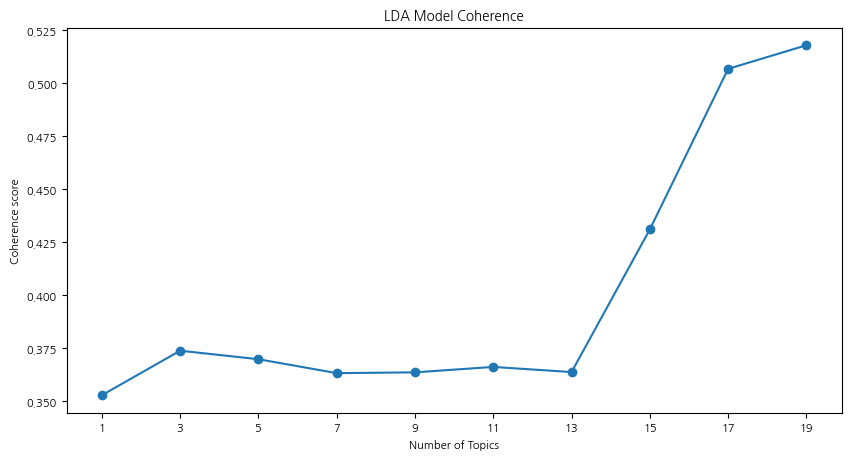

In [127]:
# Coherence score시각화
plt.figure(figsize=(10, 5))  # 그래프 크기 조절
plt.plot(range(1, 21, 2), coherence_value, marker='o')  # x축은 토픽 수, y축은 Coherence score
plt.title("LDA Model Coherence")  # 그래프 제목
plt.xlabel("Number of Topics")  # x축 라벨
plt.ylabel("Coherence score")  # y축 라벨
plt.xticks(range(1, 21, 2))  # x축 눈금 조절
plt.show()

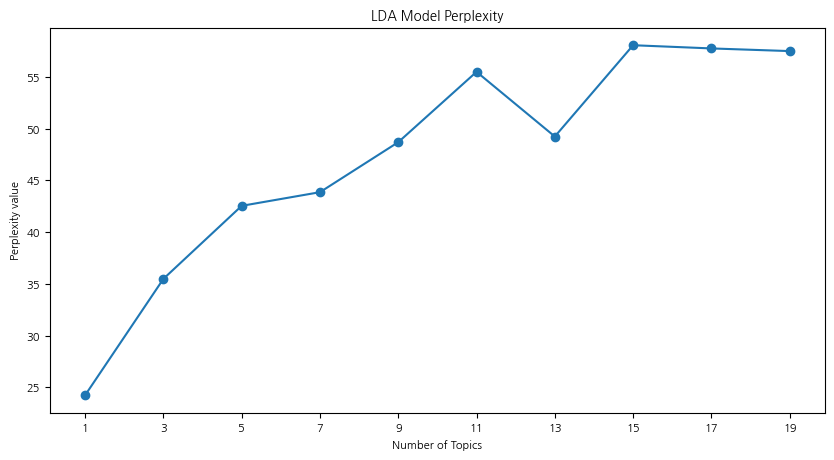

In [128]:
# Perplexity 시각화
plt.figure(figsize=(10, 5))  # 그래프 크기 조절
plt.plot(range(1, 21, 2), perplexity_values, marker='o')  # x축은 토픽 수, y축은 Perplexity
plt.title("LDA Model Perplexity")  # 그래프 제목
plt.xlabel("Number of Topics")  # x축 라벨
plt.ylabel("Perplexity value")  # y축 라벨
plt.xticks(range(1, 21, 2))  # x축 눈금 조절
plt.show()

In [144]:
# 최종 토픽 수 지정
NUM_TOPICS = 10

# LDA 모델 생성
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=4, alpha='symmetric', eta='auto', random_state=100)

In [145]:
# Jupyter notebook 내에서 시각화를 가능하게 pyLDAvis를 활성화
pyLDAvis.enable_notebook()

# LDA 모델과 해당 corpus 및 dictionary를 사용하여 시각화 준비
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)

# 생성된 시각화 출력
pyLDAvis.display(vis)

In [146]:
# 토픽별 키워드와 가중치를 데이터 프레임으로 저장
topics_df = pd.DataFrame()

for i, topic in enumerate(ldamodel.show_topics(formatted=False, num_words=40)):
    topic_keywords = ", ".join([word for word, prop in topic[1]])
    topics_df = pd.concat([topics_df, pd.DataFrame({'Topic_Num': "Topic " + str(i+1),
                                                    'Keywords': topic_keywords}, index=[0])], ignore_index=True)

# 데이터 프레임 출력
print(topics_df)

  Topic_Num                                           Keywords
0   Topic 1  좋다, 사용, 주식, 처음, 빠르다, 증권, 되다, 감사, 주, 가다, 편하다, 받...
1   Topic 2  내용, 주, 있다, 사용, 되다, 좋다, 주식, 혜택, 한국투자증권, 가다, 빠르다...
2   Topic 3  좋다, 주식, 사용, 빠르다, 증권, 처음, 편하다, 받다, 가다, 감사, 되다, ...
3   Topic 4  감사, 사용, 주식, 좋다, 빠르다, 되다, 받다, 처음, 편하다, 주, 증권, 가...
4   Topic 5  시작, 편리, 개설, 계좌, 받다, 주식, 좋다, 사용, 빠르다, 처음, 혜택, 되...
5   Topic 6  좋다, 주식, 사용, 증권, 받다, 빠르다, 혜택, 처음, 감사, 되다, 주, 한국...
6   Topic 7  좋다, 사용, 주식, 빠르다, 있다, 처음, 한국투자증권, 혜택, 받다, 개설, 증...
7   Topic 8  주식, 가다, 한국투자증권, 증권, 좋다, 사용, 빠르다, 감사, 되다, 받다, 내...
8   Topic 9  좋다, 주식, 쉽다, 모바일, 보다, 설정, 사용, 빠르다, 편하다, 증권, 되다,...
9  Topic 10  혜택, 편하다, 처음, 빠르다, 좋다, 사용, 주식, 감사, 증권, 한국투자증권, ...
